## Домашняя работа по уроку 7 (Интерпретация прогнозов модели)

##### Задание 1
взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Датасет банковских транзакций, часть из которых мошеннические

Описание данных - https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction

В домашней работе использую неполный датасет. Большая часть данных, не являющихся мошенническими операциями, удалена. Оставил данные в соотношении 1 к 3 мошеннических транзакций к легальным. Это сделано из соображений балансировки данных и сокращения размера csv файла

In [53]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [54]:
data = pd.read_csv("fraud_balanced.csv")
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,7,CASH_IN,111324.20,C926922342,4490417.58,4601741.78,C1182908789,135698.74,24374.54,0,0
1,19,CASH_OUT,143660.11,C681501417,143660.11,0.00,C447183071,0.00,143660.11,1,0
2,8,CASH_OUT,236104.53,C1000303171,45802.00,0.00,C1374917762,0.00,82985.37,0,0


##### Задание 2
сделать обзорный анализ выбранного датасета

About Dataset
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

В датасете 4 категориальных признака, 5 числовых 1 целевая переменная isFraud, а также признак isFlaggedFraud, который можно также рассматривать, как целевой. Признак isFlaggedFraud удалим из датасета, т.к. будем работать со всеми мошенническими операциями, а не только с теми, которые пометил банк. Также удалим поле step, т.к. взята только часть полного датасета

In [55]:
print(data.shape)

(32772, 11)


In [56]:
data = data.drop(['step', 'isFlaggedFraud'], 1)
data.head(3)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,CASH_IN,111324.20,C926922342,4490417.58,4601741.78,C1182908789,135698.74,24374.54,0
1,CASH_OUT,143660.11,C681501417,143660.11,0.00,C447183071,0.00,143660.11,1
2,CASH_OUT,236104.53,C1000303171,45802.00,0.00,C1374917762,0.00,82985.37,0


Посмотрим на соотношение классов

In [57]:
data.iloc[:, -1].value_counts()

0    24559
1     8213
Name: isFraud, dtype: int64

##### Задание 3
сделать feature engineering

Будем использовать модель Catboost Classification, поэтому признаки не трогаем, кроме type, чтобы в важности признаков shap визуально различать типы транзакций

In [58]:
trans_type = data.type.unique()
trans_type

array(['CASH_IN', 'CASH_OUT', 'TRANSFER', 'PAYMENT', 'DEBIT'],
      dtype=object)

In [59]:
dict_type = {i: el for el,i in enumerate(trans_type)}

In [60]:
data['type'] = data['type'].replace(dict_type)

Разбиваем выборку на тренировочную и тестовую части

In [61]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

##### Задание 4
обучить любой классификатор (какой вам нравится)

In [62]:
import catboost
from catboost import *
import shap
shap.initjs()

In [63]:
%%time
cat_features = ['type', 'nameOrig', 'nameDest']
model = catboost.CatBoostClassifier(random_state=42, silent=True, cat_features=cat_features)
model.fit(x_train, y_train)

Wall time: 1min


##### Задание 5
разобраться с SHAP и построить важности признаков для:

1. всего тестового набора данных (summary_plot - дать интерпретацию)

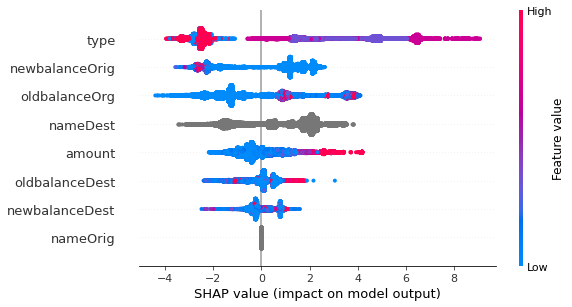

Wall time: 5.87 s


In [64]:
%%time
# С выделением категориальных фичей
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(x_data, y_data, cat_features=cat_features))

# summarize the effects of all the features
shap.summary_plot(shap_values, x_data)

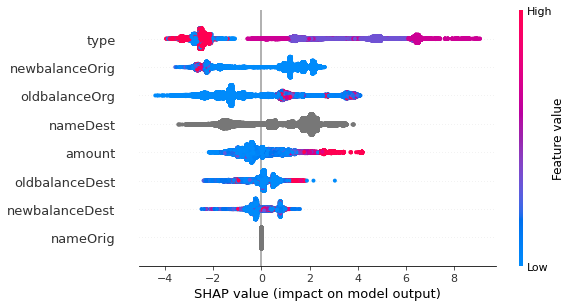

Wall time: 5.89 s


In [65]:
%%time
# Без выделения категориальных фичей. Отличий нет
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)

# summarize the effects of all the features
shap.summary_plot(shap_values, x_data)

**Выводы**
1. Основной признак - type. Судя по расцветке основные мошеннические транзакции это 1 и 2 тип транзакций ('CASH_OUT' и 'TRANSFER'), т.е. снятие наличных и межбанковский перевод, проверим:

In [66]:
print(data.loc[data['isFraud'] == 1, 'type'].unique())
print(trans_type[1:3])

[1 2]
['CASH_OUT' 'TRANSFER']


2. После мошеннической транзакции на изначальном счету, как правило, остается минимум средств или не остается вообще (newbalanceOrig)
3. Мошенническим транзакциям подвержены счета с большим балансом (oldbalanceOrg)
4. Мошеннические транзакции совершаются на крупные суммы (amount)
5. Мошеннические транзакции преимущественно производятся на счета с уже имеющимся крупным балансом (oldbalanceDest)
6. newbalanceDest не особо "говорящий" показатель, но видно, что на балансе после мошеннического перевода на целевом счету также остаются крупные суммы.

2. для топ 10%

In [67]:
spam = [sum(shap_values[i]) for i in range(len(shap_values[:,0]))]
len(spam)

32772

In [68]:
data.insert(9, 'shap_total', spam)
data.head(2)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,shap_total
0,0,111324.20,C926922342,4490417.58,4601741.78,C1182908789,135698.74,24374.54,0,-5.844800
1,1,143660.11,C681501417,143660.11,0.00,C447183071,0.00,143660.11,1,12.029944


In [69]:
sorted_data = data.sort_values(by='shap_total', ascending=False)
sorted_data.head(2)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,shap_total
7351,2,8813323.11,C1044721452,8813323.11,0.0,C61841056,0.0,0.0,1,18.207077
26954,2,8267760.50,C997276166,8267760.50,0.0,C1246358574,0.0,0.0,1,18.207077


In [70]:
top_10_data = sorted_data.iloc[0:int(sorted_data.shape[0] * 0.1)]
top_10_data.head(2)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,shap_total
7351,2,8813323.11,C1044721452,8813323.11,0.0,C61841056,0.0,0.0,1,18.207077
26954,2,8267760.50,C997276166,8267760.50,0.0,C1246358574,0.0,0.0,1,18.207077


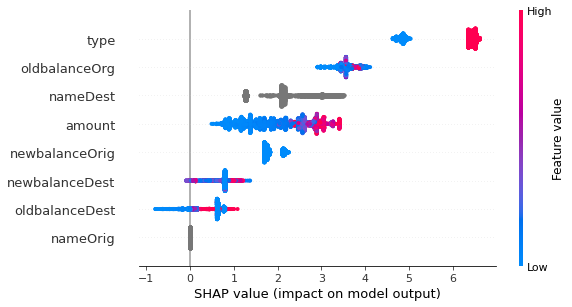

Wall time: 2.99 s


In [71]:
%%time
x_data = top_10_data.iloc[:,:-2]
y_data = top_10_data.iloc[:,-2]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(x_data, y_data, cat_features=cat_features))

# summarize the effects of all the features
shap.summary_plot(shap_values, x_data)

**Выводы:**
1. В топ 10% выборки по shap values остались только данные с положительным признаком, т.е. мошениические транзакции.
2. Остались только 2 типа транзакций - 'CASH_OUT' и 'TRANSFER', что логично.
3. Вес признака newbalanceOrig существенно снизился, т.к. в большинстве мошеннических транзакций исходный счет опустошается до 0

In [83]:
x_data.newbalanceOrig.unique(), x_data.newbalanceOrig.value_counts()

(array([0.]),
 0.0    3277
 Name: newbalanceOrig, dtype: int64)

##### Задание 6
для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [72]:
x_data.type.unique()

array([2, 1], dtype=int64)

In [73]:
x_data.iloc[2018].type, x_data.iloc[2].type

(1, 2)

In [74]:
# Type == 1
shap.force_plot(explainer.expected_value, shap_values[2018,:], x_data.iloc[2018,:])

In [75]:
# Type == 2
shap.force_plot(explainer.expected_value, shap_values[2,:], x_data.iloc[2,:])

**Выводы:**
1. Среднее значение модели в процессе обучения = -6.444.
2. Значения для наблюдений с индексами 2018 и 2 - 10.2 и 11.76 cсоответственно.
3. Наглядно видно, что наибольший вклад в смещение в сторону положительного класса вносит признак типа транзакции.
4. Остальные признаки (красные) расположены в порядке убывания своего вклада в смещение предсказания к положительному классу.
5. В случае наблюдения с индексом 2018 признак oldbalanceDest несущественно смещает предсказание к негативному классу. Т.к. мы интерпретируем результаты для двух наблюдений из топ 10%, то влияние признаков на смещение предсказания в сторону негативного класса практически отсутствует.